# 役割ベースの協調

- 『LangChain と LangGraph による RAG・AI エージェント実践入門（12 章より)』
- 今実装では、次の AI エージェントが協調してタスク実行

  - プランナー（Planner）：ユーザーから要求されたタスクを分解する
  - アサイナー（role_assigner）：それぞれのタスクをどのような役割の子エージェントが実行するべきか定義する
  - 実行者（executor）：タスクを実行するための子エージェントを生成、タスクを実行する
  - レポーター（reporter）：実行結果を報告する

- 特徴
  - あらかじめ役割を持ったエージェントを用意せず、分解されたタスクの内容に応じて、「アサイナー」が動的に役割を生成する
  - 従来は、プログラム内で使用するデータは事前に用意しておく必要があるが、LLM を活用したプログラムでは、状況に合わせその場その場で必要なデータを生成することが可能
  - 今実装では、動的に生成させるタスクの内容に対し、動的に「役割」のデータを生成する


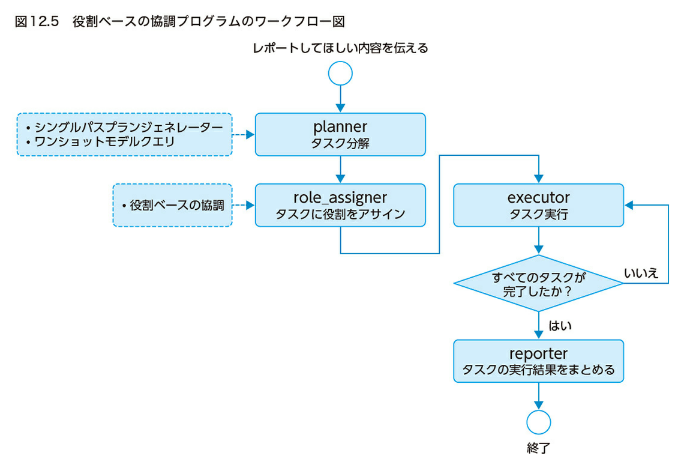

In [ ]:
from IPython.display import Image

Image("/content/drive/MyDrive/for_study_in_library/study_LangGraph/png/rb_w.png")

役割ベースの協調におけるワークフローの特徴は、タスク分解の次に、各タスクの実施において最適な役割を生成し、タスクに役割をアサインしていること。タスクへの役割のアサイン後、タスク実行を行う`executor`ノードでは、その役割に応じたエージェントを生成し、タスク実行にあたらせる


In [1]:
# !pip install langchain-core==0.3.0 langchain-community==0.3.0 \
# langgraph==0.2.22 langchain-openai==0.2.0 langchain-anthropic==0.2.0 \
# numpy==1.26.4 faiss-cpu==1.8.0.post1 \
# pydantic-settings==2.5.2 retry==0.9.2 decorator==4.4.2

In [2]:
# !pip install "pydantic<2.11"  # 例: 2.10.6 エラー回避用

In [5]:
import os

os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = LANGCHAIN_API_KEY
os.environ["LANGCHAIN_PROJECT"] = LANGCHAIN_PROJECT
os.environ["TAVILY_API_KEY"] = TAVILY_API_KEY

In [7]:
import operator
from typing import Annotated, Any

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langgraph.graph import END, StateGraph
from langgraph.prebuilt import create_react_agent
from pydantic import BaseModel, Field
from single_path_plan_generation.main import DecomposedTasks, QueryDecomposer
from pprint import pprint

## ステート設計


In [8]:
class Role(BaseModel):
    name: str = Field(..., description="役割の名前")
    description: str = Field(..., description="役割の詳細な説明")
    key_skills: list[str] = Field(..., description="この役割に必要な主要なスキルや属性")


class Task(BaseModel):
    description: str = Field(..., description="タスクの説明")
    role: Role = Field(default=None, description="タスクに割り当てられた役割")


class TasksWithRoles(BaseModel):
    tasks: list[Task] = Field(..., description="役割が割り当てられたタスクのリスト")

In [9]:
class AgentState(BaseModel):
    query: str = Field(..., description="ユーザーが入力したクエリ")
    tasks: list[Task] = Field(
        default_factory=list, description="実行するタスクのリスト"
    )
    current_task_index: int = Field(default=0, description="現在実行中のタスクの番号")
    results: Annotated[list[str], operator.add] = Field(
        default_factory=list, description="実行済みタスクの結果リスト"
    )
    final_report: str = Field(default="", description="最終的な出力結果")

- query: ユーザーによって入力されたクエリ
- tasks: ユーザー入力を基に`planner`ノードでタスク分解した結果を保持。Task モデル内の role フィールドは、`role_assigner`ノードで生成される
- current_tasi_index: 現在何番目のタスクに取り組んでいるかを保持
- results: 各タスクの実行結果を保持
- final_report: `reporter`ノードの実行結果を保持


## `planner`ノード：タスク分解

実装コード

```python
def _plan_tasks(self, state: AgentState) -> dict[str, Any]:
    tasks = self.planner.run(query=state.query)
    return {"tasks": tasks
```


In [10]:
class Planner:
    def __init__(self, llm: ChatOpenAI):
        self.query_decomposer = QueryDecomposer(llm=llm)

    def run(self, query: str) -> list[Task]:
        decomposed_tasks: DecomposedTasks = self.query_decomposer.run(query=query)
        return [Task(description=task) for task in decomposed_tasks.values]

`Planner`クラスでは、シングルパスプランジェネレーターで作成した`QueryDecomposer`クラスを利用し、ユーザーの要求からタスク分解実施


## `role_assigner`ノード：タスクに役割をアサイン

`role_assigner`ノードにより、各タスクへの役割のアサインを行う

```python
def _assign_roles(self, state: AgentState) -> dict[str, Any]:
    tasks_with_roles = self.role_assigner.run(tasks=state.tasks)
    return {"tasks": tasks_with_roles}
```


In [13]:
class RoleAssigner:
    def __init__(self, llm: ChatOpenAI):
        self.llm = llm.with_structured_output(TasksWithRoles)

    def run(self, tasks: list[Task]) -> list[Task]:
        prompt = ChatPromptTemplate(
            [
                (
                    "system",
                    (
                        "あなたは創造的な役割設計の専門家です。与えられたタスクに対して、ユニークで適切な役割を生成してください。"
                    ),
                ),
                (
                    "human",
                    (
                        "タスク:\n{tasks}\n\n"
                        "これらのタスクに対して、以下の指示に従って役割を割り当ててください：\n"
                        "1. 各タスクに対して、独自の創造的な役割を考案してください。既存の職業名や一般的な役割名にとらわれる必要はありません。\n"
                        "2. 役割名は、そのタスクの本質を反映した魅力的で記憶に残るものにしてください。\n"
                        "3. 各役割に対して、その役割がなぜそのタスクに最適なのかを説明する詳細な説明を提供してください。\n"
                        "4. その役割が効果的にタスクを遂行するために必要な主要なスキルやアトリビュートを3つ挙げてください。\n\n"
                        "創造性を発揮し、タスクの本質を捉えた革新的な役割を生成してください。"
                    ),
                ),
            ],
        )
        chain = prompt | self.llm
        tasks_with_roles = chain.invoke(
            {"tasks": "\n".join([task.description for task in tasks])}
        )

        print("生成された役割：\n")
        pprint(tasks_with_roles.tasks)
        print("==============================")

        return tasks_with_roles.tasks

## `executor`ノード：タスク実行

```python
def _execute_task(self, state: AgentState) -> dict[str, Any]:
    current_task = state.tasks[state.current_task_index]
    result = self.executor.run(task=current_task)
    return {
        "results": [result],
        "current_task_index": state.current_task_index + 1,
    }
```


In [14]:
class Executor:
    def __init__(self, llm: ChatOpenAI):
        self.llm = llm
        self.tools = [TavilySearchResults(max_results=3)]
        self.base_agent = create_react_agent(self.llm, self.tools)

    def run(self, task: Task) -> str:
        result = self.base_agent.invoke(
            {
                "messages": [
                    (
                        "system",
                        (
                            f"あなたは{task.role.name}です。\n"
                            f"説明: {task.role.description}\n"
                            f"主要なスキル: {', '.join(task.role.key_skills)}\n"
                            "あなたの役割に基づいて、与えられたタスクを最高の能力で遂行してください。"
                        ),
                    ),
                    (
                        "human",
                        f"以下のタスクを実行してください：\n\n{task.description}",
                    ),
                ]
            }
        )
        return result["messages"][-1].content

## `reporter`ノード：タスクの実行内容をまとめる

```python
def _generate_report(self, state: AgentState) -> dict[str, Any]:
    report = self.reporer.run(query=state.query, results=state.results)
    return {"final_report": report}
```


In [ ]:
class Reporter:
    def __init__(self, llm: ChatOpenAI):
        self.llm = llm

    def run(self, query: str, results: list[str]) -> str:
        prompt = ChatPromptTemplate(
            [
                (
                    "system",
                    (
                        "あなたは総合的なレポート作成の専門家です。複数の情報源からの結果を統合し、洞察力に富んだ包括的なレポートを作成する能力があります。"
                    ),
                ),
                (
                    "human",
                    (
                        "タスク: 以下の情報に基づいて、包括的で一貫性のある回答を作成してください。\n"
                        "要件:\n"
                        "1. 提供されたすべての情報を統合し、よく構成された回答にしてください。\n"
                        "2. 回答は元のクエリに直接応える形にしてください。\n"
                        "3. 各情報の重要なポイントや発見を含めてください。\n"
                        "4. 最後に結論や要約を提供してください。\n"
                        "5. 回答は詳細でありながら簡潔にし、250〜300語程度を目指してください。\n"
                        "6. 回答は日本語で行ってください。\n\n"
                        "ユーザーの依頼: {query}\n\n"
                        "収集した情報:\n{results}"
                    ),
                ),
            ],
        )
        chain = prompt | self.llm | StrOutputParser()
        return chain.invoke(
            {
                "query": query,
                "results": "\n\n".join(
                    f"Info {i + 1}:\n{result}" for i, result in enumerate(results)
                ),
            }
        )

## グラフ作成


In [16]:
class RoleBasedCooperation:
    def __init__(self, llm: ChatOpenAI):
        self.llm = llm
        self.planner = Planner(llm=llm)
        self.role_assigner = RoleAssigner(llm=llm)
        self.executor = Executor(llm=llm)
        self.reporter = Reporter(llm=llm)
        self.graph = self._create_graph()

    def _create_graph(self) -> StateGraph:
        workflow = StateGraph(AgentState)

        workflow.add_node("planner", self._plan_tasks)
        workflow.add_node("role_assigner", self._assign_roles)
        workflow.add_node("executor", self._execute_task)
        workflow.add_node("reporter", self._generate_report)

        workflow.set_entry_point("planner")

        workflow.add_edge("planner", "role_assigner")
        workflow.add_edge("role_assigner", "executor")
        workflow.add_conditional_edges(
            "executor",
            lambda state: state.current_task_index < len(state.tasks),
            {True: "executor", False: "reporter"},
        )

        workflow.add_edge("reporter", END)

        return workflow.compile()

    def _plan_tasks(self, state: AgentState) -> dict[str, Any]:
        tasks = self.planner.run(query=state.query)
        return {"tasks": tasks}

    def _assign_roles(self, state: AgentState) -> dict[str, Any]:
        tasks_with_roles = self.role_assigner.run(tasks=state.tasks)
        return {"tasks": tasks_with_roles}

    def _execute_task(self, state: AgentState) -> dict[str, Any]:
        current_task = state.tasks[state.current_task_index]
        result = self.executor.run(task=current_task)
        return {
            "results": [result],
            "current_task_index": state.current_task_index + 1,
        }

    def _generate_report(self, state: AgentState) -> dict[str, Any]:
        report = self.reporter.run(query=state.query, results=state.results)
        return {"final_report": report}

    def run(self, query: str) -> str:
        initial_state = AgentState(query=query)
        final_state = self.graph.invoke(initial_state, {"recursion_limit": 1000})
        return final_state["final_report"]

## 実行


In [ ]:
query = "カレーライスの作り方"

llm = ChatOpenAI(model="gpt-4o", temperature=0.0)

agent = RoleBasedCooperation(llm=llm)

result = agent.run(query=query)

pprint(result)

生成された役割：

[Task(description='インターネットでカレーライスの基本的なレシピを検索し、信頼できるサイトを選ぶ。', role=Role(name='レシピ探求者', description='カレーライスの基本的なレシピをインターネットで探し出し、信頼性の高い情報源を選定する役割。情報の海から最も信頼できる情報を見つけ出すことに特化している。', key_skills=['情報検索能力', '批判的思考', '信頼性評価'])),
 Task(description='選んだレシピの材料と手順を詳細にメモする。', role=Role(name='レシピ記録者', description='選定したレシピの材料と手順を正確かつ詳細に記録する役割。情報を整理し、後で参照しやすい形で保存することに長けている。', key_skills=['詳細な記録能力', '整理整頓能力', '注意深さ'])),
 Task(description='レシピに基づいて必要な材料と調理器具をリストアップする。', role=Role(name='キッチン準備マエストロ', description='レシピに基づいて必要な材料と調理器具をリストアップし、調理の準備を整える役割。効率的な準備と計画が得意。', key_skills=['計画能力', 'リスト作成能力', '効率性'])),
 Task(description='材料の購入先や価格をインターネットで調査し、購入計画を立てる。', role=Role(name='ショッピング戦略家', description='材料の購入先や価格を調査し、最もコストパフォーマンスの良い購入計画を立てる役割。市場調査と価格比較に優れている。', key_skills=['市場調査能力', '価格比較能力', '計画立案能力'])),
 Task(description='調理手順を確認し、実際にカレーライスを作る際の注意点やコツをインターネットで調べる。', role=Role(name='調理知識探求者', description='調理手順を確認し、カレーライスを作る際の注意点やコツをインターネットで探し出す役割。調理の成功を確実にするための知識を集めることに特化している。', key_skills=['調理知識収